## In Computer Vision, different levels of tasks build on one another, ranging from basic image classification to more advanced forms of object localization, detection, and segmentation. Below is an explanation of these tasks along with Python code examples using libraries like TensorFlow, Keras, and OpenCV

# Level 1: Classification

## In image classification, the task is to classify an entire image into a specific category. For example, given an image of a cat or dog, the model predicts if it's a "cat" or "dog."

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.1204 - loss: 2.2840 - val_accuracy: 0.1850 - val_loss: 2.2368
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.2175 - loss: 2.1368 - val_accuracy: 0.2200 - val_loss: 2.1806
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2409 - loss: 2.0277 - val_accuracy: 0.2500 - val_loss: 2.0135
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3204 - loss: 1.8310 - val_accuracy: 0.3350 - val_loss: 1.9235
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3633 - loss: 1.7462 - val_accuracy: 0.3100 - val_loss: 1.8734
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3801 - loss: 1.6869 - val_accuracy: 0.3300 - val_loss: 1.8871
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4189 - loss: 1.6012 - val_accuracy: 0.3350 - val_loss: 1.7766
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4343 - loss: 1.5394 - val_accuracy: 0.3550 - v

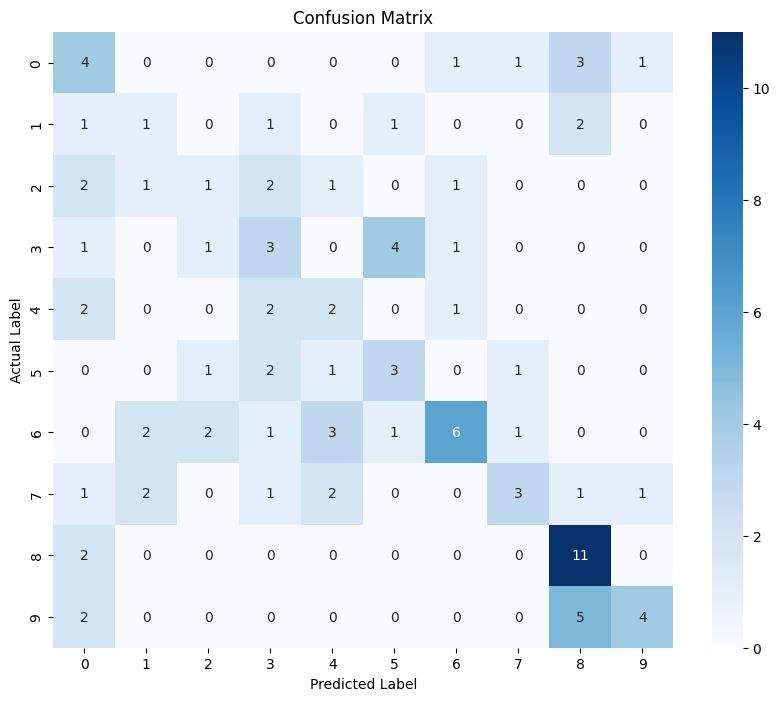

Model saved to disk.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Predicted label: airplane


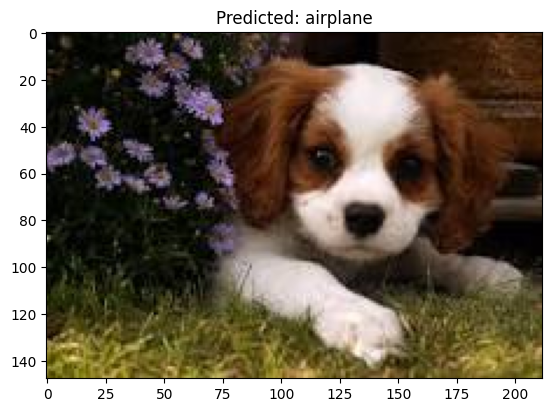

In [12]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV for noise reduction and image preprocessing
import os
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# 1. Load and Preprocess Data

# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Limit the dataset for a low-end system (use only 5000 images)
train_images, train_labels = train_images[:1000], train_labels[:1000]
test_images, test_labels = test_images[:100], test_labels[:100]

# Normalize pixel values to be between 0 and 1 (initial normalization)
train_images, test_images = train_images / 255.0, test_images / 255.0

# 2. Image Preprocessing (Denoising and Resizing)
def preprocess_image(image):
    # Convert image back to 0-255 scale for OpenCV denoising function
    image = np.uint8(image * 255)
    
    # Denoising the image using OpenCV's fastNlMeansDenoisingColored
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    
    # Resizing the image to (32, 32)
    resized_image = cv2.resize(denoised_image, (32, 32))
    
    # Normalize back to 0-1 after preprocessing
    resized_image = resized_image / 255.0
    
    return resized_image

# Apply preprocessing to the entire dataset
train_images = np.array([preprocess_image(img) for img in train_images])
test_images = np.array([preprocess_image(img) for img in test_images])

# 3. Define a Simple CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)  # 10 classes in CIFAR-10
])

# 4. Compile the Model
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# 5. Train the Model (with validation split)
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_split=0.2, batch_size=32)


# 6. Evaluate the Model and Generate Confusion Matrix
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Reshape labels to match predictions
test_labels_flat = test_labels.flatten()

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_flat, test_predictions_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 7. Save the Model
model.save('cnn_cifar10_model.h5')
print("Model saved to disk.")

# 8. Load the Saved Model and Predict on a New Image
def predict_on_new_image(image_path):
    # Load the saved model
    loaded_model = models.load_model('cnn_cifar10_model.h5')
    
    # Load and preprocess the new image
    new_image = cv2.imread(image_path)
    new_image = preprocess_image(new_image)  # Apply preprocessing
    new_image = np.expand_dims(new_image, axis=0)  # Add batch dimension
    
    # Make predictions
    predictions = loaded_model.predict(new_image)
    predicted_label = np.argmax(predictions, axis=1)
    
    # CIFAR-10 class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    print(f"Predicted label: {class_names[predicted_label[0]]}")
    
    # Display the image
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted: {class_names[predicted_label[0]]}')
    plt.show()

# Example: Call prediction on a new image (replace 'sample_image.jpg' with your image path)
new_image_path = 'sample_image.jpg'
if os.path.exists(new_image_path):
    predict_on_new_image(new_image_path)
else:
    print(f"New image file not found at path: {new_image_path}")

# Level 2: Classification and Localization

## In classification and localization, the task is to both classify the object in the image and predict its bounding box. For example, the model predicts that there's a "cat" and also localizes its position within the image.

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - classification_accuracy: 0.1001 - classification_loss: 2.5558 - localization_loss: 192.0318 - localization_mean_absolute_error: 11.0648 - loss: 194.6905 - val_classification_accuracy: 0.1110 - val_classification_loss: 2.3851 - val_localization_loss: 35.1972 - val_localization_mean_absolute_error: 4.8619 - val_loss: 37.7315
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - classification_accuracy: 0.1112 - classification_loss: 2.3756 - localization_loss: 32.7255 - localization_mean_absolute_error: 4.6746 - loss: 35.0965 - val_classification_accuracy: 0.1330 - val_classification_loss: 2.3946 - val_localization_loss: 30.7182 - val_localization_mean_absolute_error: 4.6059 - val_loss: 33.2322
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - classification_accuracy: 0.1324 - classification_loss: 2.3691 - localization_loss: 29.9794 - localization_mean_absolute_error: 4.5404 - loss: 32.3584 - val_classification_accuracy: 0.1090 - val_

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy: 18.40%


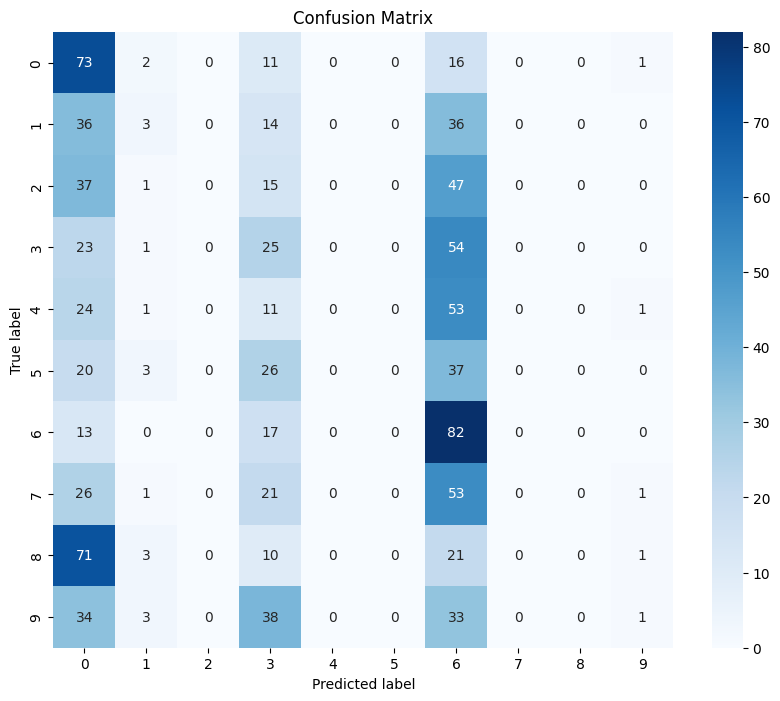

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Predictions from the loaded model:


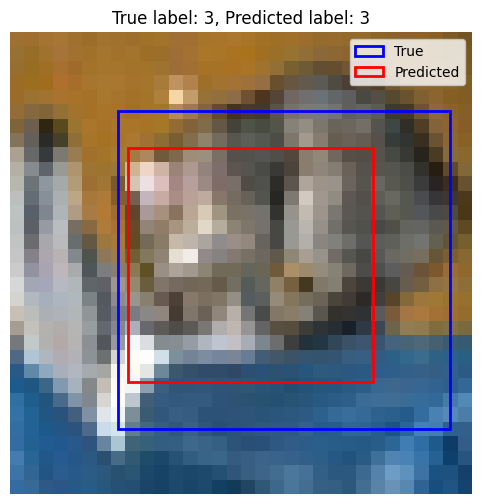

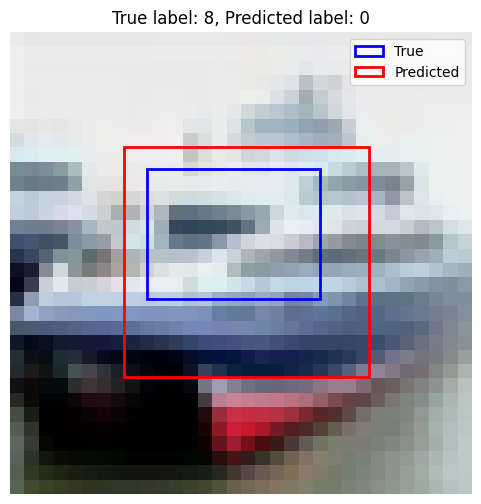

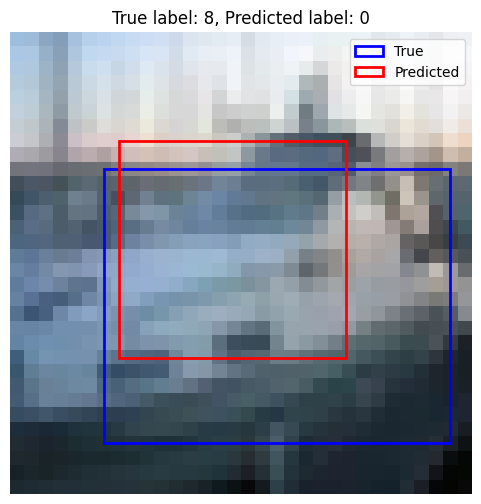

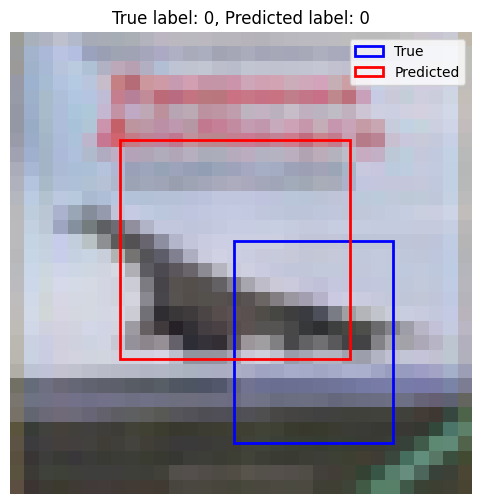

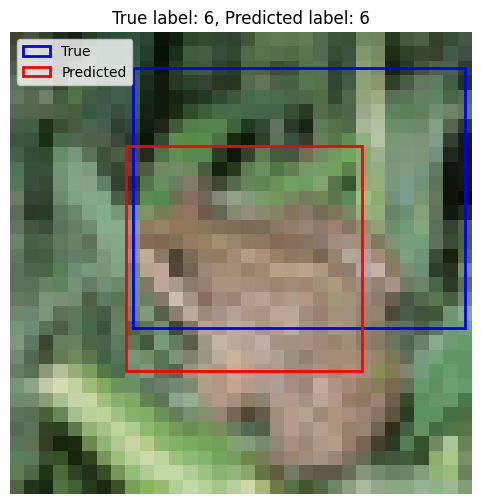

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import os

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Use only 2000 training and 1000 testing samples
X_train, y_train = X_train[:2000], y_train[:2000]
X_test, y_test = X_test[:1000], y_test[:1000]

# Generate random bounding boxes for training and testing datasets
def create_random_bboxes(images):
    bboxes = []
    for img in images:
        height, width, _ = img.shape
        x1 = np.random.randint(0, width // 2)
        y1 = np.random.randint(0, height // 2)
        x2 = np.random.randint(width // 2, width)
        y2 = np.random.randint(height // 2, height)
        bboxes.append([x1, y1, x2, y2])
    return np.array(bboxes)

y_train_bboxes = create_random_bboxes(X_train)
y_test_bboxes = create_random_bboxes(X_test)

# Normalize images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Build model
def build_model():
    input_layer = layers.Input(shape=(32, 32, 3))

    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    classification_output = layers.Dense(10, activation='softmax', name='classification')(x)
    localization_output = layers.Dense(4, name='localization')(x)

    model = models.Model(inputs=input_layer, outputs=[classification_output, localization_output])
    
    return model

model = build_model()

# Compile the model
model.compile(optimizer='adam', 
              loss={'classification': 'sparse_categorical_crossentropy', 'localization': 'mean_squared_error'},
              metrics={'classification': 'accuracy', 'localization': 'mean_absolute_error'})

# Train the model
history = model.fit(X_train, 
                    {'classification': y_train, 'localization': y_train_bboxes},
                    validation_data=(X_test, 
                                     {'classification': y_test, 'localization': y_test_bboxes}),
                    epochs=10, 
                    batch_size=64)

# Save the model
model.save('image_classification_localization_model.h5')

# Make predictions
predictions = model.predict(X_test)
predicted_bboxes = predictions[1]
predicted_labels = np.argmax(predictions[0], axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, predicted_labels)
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Print accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Visualization function
def visualize_predictions(images, true_bboxes, predicted_bboxes, true_labels, predicted_labels):
    for i in range(5):  # Visualize 5 images
        img = images[i]
        true_bbox = true_bboxes[i]
        predicted_bbox = predicted_bboxes[i]
        true_label = true_labels[i]
        predicted_label = predicted_labels[i]

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')

        # Draw true bounding box
        plt.gca().add_patch(plt.Rectangle((true_bbox[0], true_bbox[1]), 
                                            true_bbox[2] - true_bbox[0], 
                                            true_bbox[3] - true_bbox[1], 
                                            edgecolor='blue', 
                                            linewidth=2, 
                                            fill=False, label='True'))

        # Draw predicted bounding box
        plt.gca().add_patch(plt.Rectangle((predicted_bbox[0], predicted_bbox[1]), 
                                            predicted_bbox[2] - predicted_bbox[0], 
                                            predicted_bbox[3] - predicted_bbox[1], 
                                            edgecolor='red', 
                                            linewidth=2, 
                                            fill=False, label='Predicted'))

        plt.title(f'True label: {true_label}, Predicted label: {predicted_label}')
        plt.legend()
        plt.show()

# Visualize the results
#visualize_predictions(X_test, y_test_bboxes, predicted_bboxes, y_test.flatten(), predicted_labels)

# Load the saved model and make predictions
loaded_model = models.load_model('image_classification_localization_model.h5')
loaded_predictions = loaded_model.predict(X_test)
loaded_predicted_bboxes = loaded_predictions[1]
loaded_predicted_labels = np.argmax(loaded_predictions[0], axis=1)

# Visualize predictions from the loaded model
print("Predictions from the loaded model:")
visualize_predictions(X_test, y_test_bboxes, loaded_predicted_bboxes, y_test.flatten(), loaded_predicted_labels)

# Level 3: Object Detection

## In object detection, the task is to detect multiple objects in an image and predict both their classes and bounding boxes. A well-known algorithm for this task is YOLO (You Only Look Once) or Faster R-CNN.

In [ ]:
#https://www.youtube.com/watch?v=m9fH9OWn8YM
#https://www.analyticsvidhya.com/blog/2018/06/understanding-building-object-detection-model-python/
#https://www.freecodecamp.org/news/how-to-detect-objects-in-images-using-yolov8/

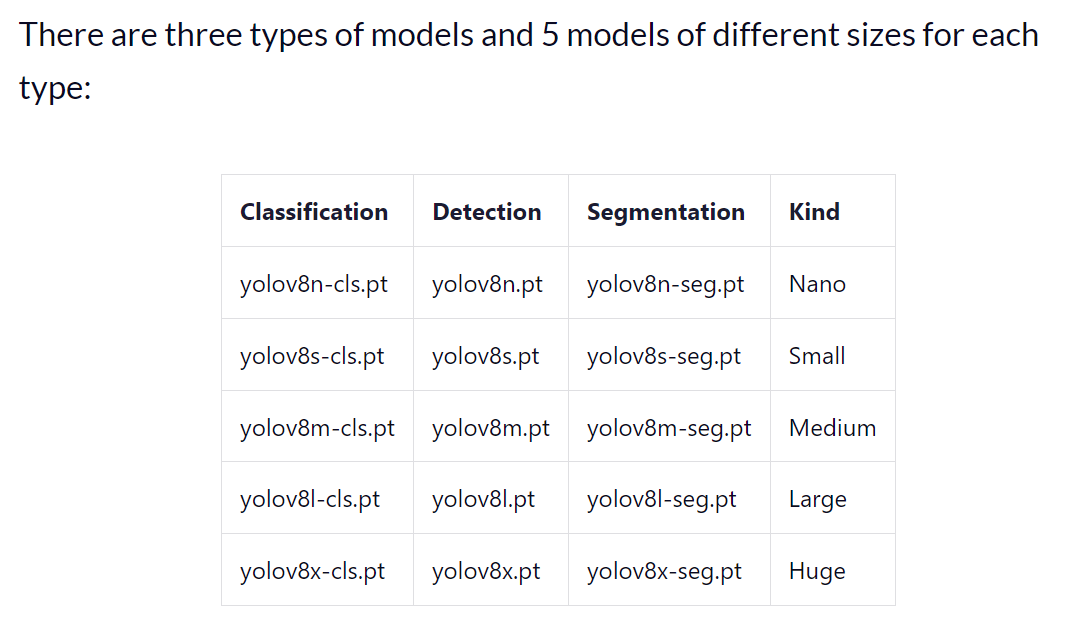

In [1]:
import os

# Get the current working directory
cwd = os.getcwd()

print("Current Working Directory:", cwd)

Current Working Directory: C:\Users\Abhishek_Jaiswal\Documents\Image


In [2]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

PyTorch version: 2.4.1+cpu
torchvision version: 0.19.1+cpu


In [3]:
from ultralytics import YOLO
import yaml
import cv2
from matplotlib import pyplot as plt

In [4]:
model = YOLO("yolov8m.pt")

In [5]:
model.predict("C:/Users/Abhishek_Jaiswal/Documents/Image/sample_image.jpg" , save = True , save_txt = True)


image 1/1 C:\Users\Abhishek_Jaiswal\Documents\Image\sample_image.jpg: 448x640 1 dog, 502.7ms
Speed: 10.5ms preprocess, 502.7ms inference, 3.8ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict2
1 label saved to runs\detect\predict2\labels


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [7]:
lis = open("C:/Users/Abhishek_Jaiswal/Documents/Image/runs/detect/predict2/labels/sample_image.txt" , "r").readlines()
lis


['16 0.648994 0.516507 0.626516 0.876143\n']

In [11]:
file_name = "C:/Users/Abhishek_Jaiswal/AppData/Local/miniconda3/envs/mlenv/Lib/site-packages/ultralytics/cfg/datasets/coco8.yaml"
import yaml
# Open the file with UTF-8 encoding
with open(file_name, "r", encoding="utf-8") as stream:
    names = yaml.safe_load(stream)["names"]
print(names)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [12]:
for l in lis:
  ind = int(l.split()[0])
  print(ind , names[ind])

16 dog


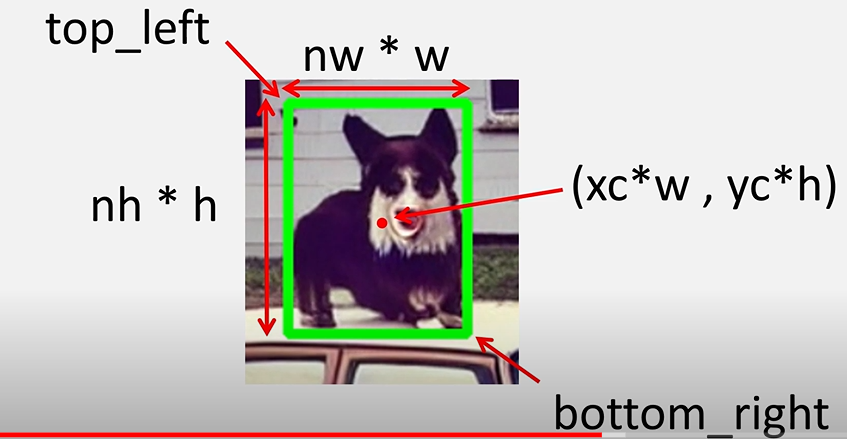

In [14]:
float("0.21875\n")
li = lis[0].split()
xc , yc , nw , nh = float(li[1]) , float(li[2]) , float(li[3]) , float(li[4])

In [18]:
img = cv2.imread("C:/Users/Abhishek_Jaiswal/Documents/Image/sample_image.jpg")
h , w = img.shape[0] , img.shape[1]


xc *= w
yc *= h
nw *= w
nh *= h
top_left = (int(xc - nw/2) , int(yc - nh/2))
bottom_right = (int(xc + nw/2) , int(yc + nh/2))

top_left , bottom_right

((15089, 1718), (43247, 20909))

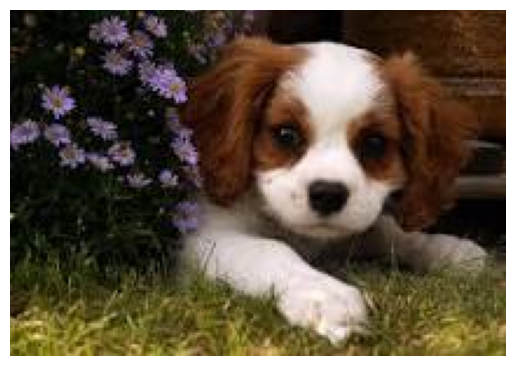

In [20]:
import cv2
from matplotlib import pyplot as plt

# Your image processing code
img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 3)

# Convert BGR to RGB for proper display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Hide the axis
plt.show()

In [21]:
#Predict
model.predict("C:/Users/Abhishek_Jaiswal/Documents/Image/sample_image2.jpg" , save = True , save_txt = True)


image 1/1 C:\Users\Abhishek_Jaiswal\Documents\Image\sample_image2.jpg: 480x640 2 persons, 1 dog, 512.4ms
Speed: 4.5ms preprocess, 512.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict2
2 labels saved to runs\detect\predict2\labels


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

# Level 4: Object Semantic Segmentation

## In semantic segmentation, the task is to classify each pixel in the image, assigning it to a class. Unlike object detection, where we get bounding boxes, here we get a pixel-wise classification.

In [23]:
from ultralytics import YOLO
import cv2
import numpy as np
import yaml
from matplotlib import pyplot as plt

In [31]:
model = YOLO("yolov8m-seg.pt")
predict = model.predict("C:/Users/Abhishek_Jaiswal/Documents/Image/sample_image4.jpg" , save = True , save_txt = True)


image 1/1 C:\Users\Abhishek_Jaiswal\Documents\Image\sample_image4.jpg: 576x640 1 bicycle, 1 car, 1 dog, 694.9ms
Speed: 5.0ms preprocess, 694.9ms inference, 7.0ms postprocess per image at shape (1, 3, 576, 640)
Results saved to runs\segment\predict2
1 label saved to runs\segment\predict2\labels


In [32]:
predict[0].masks.data[0].unique()

tensor([0., 1.])

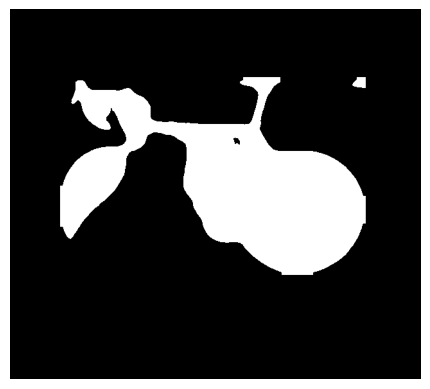

In [33]:
import cv2
from matplotlib import pyplot as plt

# Load the image
img = cv2.imread("C:/Users/Abhishek_Jaiswal/Documents/Image/sample_image4.jpg")
H, W, _ = img.shape

# Assuming predict[0].masks is a valid object and holds the masks
mask = predict[0].masks.data[0].numpy() * 255  # Access the mask data and scale it to 0-255
mask_uint8 = mask.astype("uint8")

# Display the mask using matplotlib
plt.imshow(mask_uint8, cmap='gray')
plt.axis('off')  # Hide the axis
plt.show()



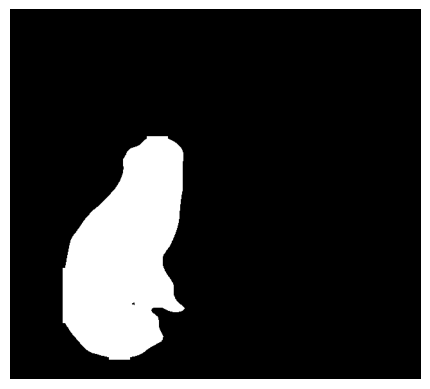

In [34]:
# Assuming predict[0].masks is a valid object and holds the masks
mask = predict[0].masks.data[1].numpy() * 255  # Access the mask data and scale it to 0-255
mask_uint8 = mask.astype("uint8")

# Display the mask using matplotlib
plt.imshow(mask_uint8, cmap='gray')
plt.axis('off')  # Hide the axis
plt.show()

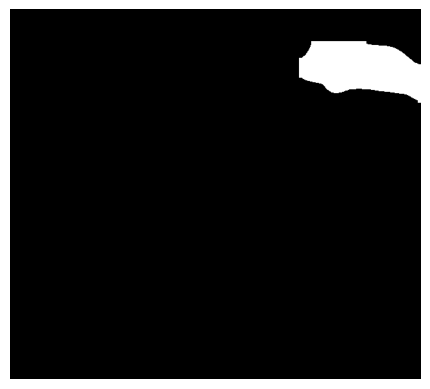

In [35]:
# Assuming predict[0].masks is a valid object and holds the masks
mask = predict[0].masks.data[2].numpy() * 255  # Access the mask data and scale it to 0-255
mask_uint8 = mask.astype("uint8")

# Display the mask using matplotlib
plt.imshow(mask_uint8, cmap='gray')
plt.axis('off')  # Hide the axis
plt.show()

### Handling noise and difficulties in images and videos is an important aspect of computer vision tasks. These issues can significantly degrade the performance of machine learning models. Below are some common challenges and techniques to handle them, along with code examples.

## Common Issues in Images and Videos

### 1. Noise: This refers to random variations in brightness or color information in images or videos. Noise can be introduced due to low lighting, camera sensors, or environmental conditions.
### 2. Blurriness: Poor focus or motion can cause blurry images, making it difficult for models to extract meaningful features.
### 3. Illumination Variation: Inconsistent lighting conditions can affect the appearance of objects.
### 4. Occlusion: Objects being partially obscured by other objects in the scene can make it difficult to identify or classify them.
### 5. Rotation and Scale Variation: Objects might appear in various orientations and sizes.
### 6. Compression Artifacts: Compression of images and videos can introduce artifacts, reducing the quality of the data.
### 7. Video Processing Challenges: Videos introduce temporal issues like motion tracking, video stabilization, and frame drops.

# Techniques for Handling Noise and Other Issues

## 1. Denoising (Handling Noise)
### Noise in images can be reduced using filtering techniques. One of the most common methods is Gaussian Blur, which smooths the image. Another popular approach is Median Filtering, which preserves edges better while removing noise.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a noisy image
image = cv2.imread('noisy_image.jpg')

# Apply Gaussian Blur to reduce noise
gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)

# Apply Median Filtering for better edge preservation
median_filtered = cv2.medianBlur(image, 5)

# Display the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Noisy Image')
plt.subplot(1, 3, 2), plt.imshow(cv2.cvtColor(gaussian_blur, cv2.COLOR_BGR2RGB)), plt.title('Gaussian Blur')
plt.subplot(1, 3, 3), plt.imshow(cv2.cvtColor(median_filtered, cv2.COLOR_BGR2RGB)), plt.title('Median Filter')
plt.show()

### Advanced Denoising with Non-Local Means
### For more advanced denoising, you can use the Non-Local Means Denoising algorithm, which works well on images with a significant amount of noise while preserving important details.

In [ ]:
# Denoising using Non-Local Means Denoising
denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

# Display the denoised image
plt.imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))
plt.title('Denoised Image (Non-Local Means)')
plt.show()

## 2. Handling Blurriness
### Blurriness can be due to poor camera focus or motion. De-blurring techniques attempt to sharpen images. A basic method for deblurring is using an Unsharp Masking technique.

In [ ]:
# Unsharp Masking (Deblurring)
blurred_image = cv2.GaussianBlur(image, (9, 9), 10.0)
unsharp_image = cv2.addWeighted(image, 1.5, blurred_image, -0.5, 0)

# Display the result
plt.imshow(cv2.cvtColor(unsharp_image, cv2.COLOR_BGR2RGB))
plt.title('Deblurred Image (Unsharp Masking)')
plt.show()

## 3. Handling Illumination Variation
### Histogram Equalization is used to improve contrast and handle illumination issues. It redistributes the intensity values to enhance the overall contrast of the image.

In [ ]:
# Convert to grayscale for histogram equalization
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Histogram Equalization
equalized_image = cv2.equalizeHist(gray_image)

# Display the result
plt.imshow(equalized_image, cmap='gray')
plt.title('Histogram Equalized Image')
plt.show()

### CLAHE (Contrast Limited Adaptive Histogram Equalization)
### For better control over illumination, especially in specific regions, you can use CLAHE, which works better in high-contrast areas.

In [ ]:
# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_image = clahe.apply(gray_image)

# Display the result
plt.imshow(clahe_image, cmap='gray')
plt.title('CLAHE Enhanced Image')
plt.show()


## 4. Handling Occlusion
### Occlusion is a challenging problem. Techniques like data augmentation (introducing occlusion artificially) and template matching or object tracking can be used to handle occluded objects.

In [ ]:
# Load template and main image
template = cv2.imread('template.jpg', 0)
main_image = cv2.imread('image_with_occlusion.jpg', 0)

# Apply template matching
res = cv2.matchTemplate(main_image, template, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

# Draw bounding box on detected area
top_left = max_loc
h, w = template.shape
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(main_image, top_left, bottom_right, 255, 2)

# Display the result
plt.imshow(main_image, cmap='gray')
plt.title('Template Matching with Occlusion')
plt.show()

## 5. Handling Rotation and Scale Variations
### Data augmentation is often used to handle different orientations and sizes of objects in images. Augmentation techniques like rotation, scaling, and flipping help models become more robust.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with augmentation
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, 
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

# Load a sample image
image = np.expand_dims(train_images[0], 0)

# Generate augmented images
for i, aug_img in enumerate(datagen.flow(image, batch_size=1)):
    plt.subplot(1, 5, i+1)
    plt.imshow(aug_img[0])
    plt.axis('off')
    if i == 4:
        break
plt.show()


## 6. Compression Artifacts
### Compression artifacts arise due to lossy compression, often in JPEG or video codecs. Denoising techniques like Non-Local Means (used above) or using high-quality image formats can help mitigate this issue.

## 7. Challenges with Video Processing
### In videos, you encounter challenges like frame drop, motion blur, and synchronization. Optical flow is a technique used to estimate the motion of objects between video frames. Video stabilization algorithms can help with shaky videos.

In [ ]:
import cv2

# Open video capture
cap = cv2.VideoCapture('input_video.mp4')

# Define transformation matrix for stabilization
stabilizer = cv2.createStabilizer()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Apply video stabilization
    stabilized_frame = stabilizer.stabilize(frame)

    # Display stabilized frame
    cv2.imshow('Stabilized Video', stabilized_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


## Summary of Techniques:

### Noise Reduction: Gaussian blur, Median filtering, Non-Local Means denoising.
### Deblurring: Unsharp masking, motion deblurring algorithms.
### Illumination Handling: Histogram equalization, CLAHE.
### Occlusion: Template matching, object tracking, and data augmentation.
### Rotation/Scale Variation: Data augmentation.
### Compression Artifacts: Non-Local Means denoising.
### Video Processing Challenges: Optical flow, video stabilization.